In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.stage2 import generate_2nd_stage_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["2nd_stage"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['2nd_stage']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-22 06:48:01.543906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 06:48:01.618734: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-22 06:48:02.124081: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_095


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_2nd_stage_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [02:25<00:00,  1.90it/s]


,anglez,anglez_diff_abs,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,target,...,enmo_rolling_std_100_shift_1000,anglez_diff_abs_rolling_std_100_shift_1000,enmo_rolling_max_100_shift_1000,anglez_diff_abs_rolling_max_100_shift_1000,enmo_rolling_median_100_shift_1000,anglez_diff_abs_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_rolling_square_mean_100_shift_1000,reduce_step,fold
622,-1.160092,5.391342,-1.160092,0.049821,0.022942,0.049822,1797.5,6.5,32397.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14939,3
623,-6.169150,4.236796,-6.169149,0.026333,0.008512,0.026335,117.5,0.0,32517.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14963,3
624,-14.701716,3.183992,-14.701717,0.033279,0.007212,0.033278,237.5,0.0,32637.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14987,3
625,-12.253108,3.600733,-12.253112,0.057471,0.028133,0.057472,357.5,0.0,32757.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15011,3
626,-6.187904,3.673754,-6.187906,0.049892,0.030817,0.049891,477.5,0.0,32877.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15035,3


(877617, 656)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG["2nd_stage"]["xgboost"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_{event}_fold_{i}.model'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)


with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.81851
[100]	eval-rmse:1.14279
[200]	eval-rmse:0.97987
[300]	eval-rmse:0.94004
[400]	eval-rmse:0.92467
[500]	eval-rmse:0.91909
[600]	eval-rmse:0.91637
[700]	eval-rmse:0.91429
[800]	eval-rmse:0.91275
[900]	eval-rmse:0.91142
[1000]	eval-rmse:0.91047
[1100]	eval-rmse:0.90999
[1200]	eval-rmse:0.90934
[1300]	eval-rmse:0.90902
[1400]	eval-rmse:0.90861
[1500]	eval-rmse:0.90829
[1600]	eval-rmse:0.90779
[1700]	eval-rmse:0.90742
[1800]	eval-rmse:0.90714
[1900]	eval-rmse:0.90697
[2000]	eval-rmse:0.90661
[2100]	eval-rmse:0.90633
[2200]	eval-rmse:0.90600
[2300]	eval-rmse:0.90583
[2400]	eval-rmse:0.90562
[2500]	eval-rmse:0.90545
[2600]	eval-rmse:0.90544
[2697]	eval-rmse:0.90543


 20%|██        | 1/5 [01:30<06:01, 90.35s/it]

== fold 1 ==
[0]	eval-rmse:1.70178
[100]	eval-rmse:1.08857
[200]	eval-rmse:0.94322
[300]	eval-rmse:0.90694
[400]	eval-rmse:0.89285
[500]	eval-rmse:0.88584
[600]	eval-rmse:0.88212
[700]	eval-rmse:0.87981
[800]	eval-rmse:0.87787
[900]	eval-rmse:0.87623
[1000]	eval-rmse:0.87482
[1100]	eval-rmse:0.87373
[1200]	eval-rmse:0.87292
[1300]	eval-rmse:0.87204
[1400]	eval-rmse:0.87117
[1500]	eval-rmse:0.87047
[1600]	eval-rmse:0.86995
[1700]	eval-rmse:0.86971
[1800]	eval-rmse:0.86931
[1900]	eval-rmse:0.86913
[2000]	eval-rmse:0.86888
[2100]	eval-rmse:0.86862
[2200]	eval-rmse:0.86826
[2300]	eval-rmse:0.86806
[2400]	eval-rmse:0.86820
[2411]	eval-rmse:0.86812


 40%|████      | 2/5 [02:51<04:14, 84.72s/it]

== fold 2 ==
[0]	eval-rmse:1.73979
[100]	eval-rmse:1.12019
[200]	eval-rmse:0.97315
[300]	eval-rmse:0.93537
[400]	eval-rmse:0.92173
[500]	eval-rmse:0.91586
[600]	eval-rmse:0.91260
[700]	eval-rmse:0.91029
[800]	eval-rmse:0.90864
[900]	eval-rmse:0.90712
[1000]	eval-rmse:0.90596
[1100]	eval-rmse:0.90538
[1200]	eval-rmse:0.90480
[1300]	eval-rmse:0.90457
[1400]	eval-rmse:0.90424
[1500]	eval-rmse:0.90412
[1565]	eval-rmse:0.90413


 60%|██████    | 3/5 [03:44<02:20, 70.45s/it]

== fold 3 ==
[0]	eval-rmse:1.71261
[100]	eval-rmse:1.07180
[200]	eval-rmse:0.91558
[300]	eval-rmse:0.87581
[400]	eval-rmse:0.86405
[500]	eval-rmse:0.85910
[600]	eval-rmse:0.85754
[700]	eval-rmse:0.85681
[800]	eval-rmse:0.85555
[900]	eval-rmse:0.85514
[1000]	eval-rmse:0.85482
[1100]	eval-rmse:0.85481
[1176]	eval-rmse:0.85476


 80%|████████  | 4/5 [04:27<00:59, 59.44s/it]

== fold 4 ==
[0]	eval-rmse:1.78939
[100]	eval-rmse:1.13296
[200]	eval-rmse:0.97573
[300]	eval-rmse:0.93634
[400]	eval-rmse:0.92398
[500]	eval-rmse:0.92001
[600]	eval-rmse:0.91776
[700]	eval-rmse:0.91605
[800]	eval-rmse:0.91505
[900]	eval-rmse:0.91428
[1000]	eval-rmse:0.91331
[1100]	eval-rmse:0.91305
[1200]	eval-rmse:0.91289
[1300]	eval-rmse:0.91286
[1367]	eval-rmse:0.91288


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.81522
[100]	eval-rmse:1.15368
[200]	eval-rmse:0.98074
[300]	eval-rmse:0.93132
[400]	eval-rmse:0.91405
[500]	eval-rmse:0.90871
[600]	eval-rmse:0.90614
[700]	eval-rmse:0.90481
[800]	eval-rmse:0.90420
[900]	eval-rmse:0.90359
[1000]	eval-rmse:0.90304
[1100]	eval-rmse:0.90271
[1200]	eval-rmse:0.90232
[1300]	eval-rmse:0.90215
[1400]	eval-rmse:0.90205
[1500]	eval-rmse:0.90189
[1600]	eval-rmse:0.90173
[1700]	eval-rmse:0.90140
[1800]	eval-rmse:0.90134
[1900]	eval-rmse:0.90123
[2000]	eval-rmse:0.90107
[2100]	eval-rmse:0.90093
[2200]	eval-rmse:0.90093
[2240]	eval-rmse:0.90093


 20%|██        | 1/5 [01:13<04:54, 73.70s/it]

== fold 1 ==
[0]	eval-rmse:1.69779
[100]	eval-rmse:1.09549
[200]	eval-rmse:0.94382
[300]	eval-rmse:0.90066
[400]	eval-rmse:0.88314
[500]	eval-rmse:0.87643
[600]	eval-rmse:0.87230
[700]	eval-rmse:0.87028
[800]	eval-rmse:0.86875
[900]	eval-rmse:0.86783
[1000]	eval-rmse:0.86687
[1100]	eval-rmse:0.86633
[1200]	eval-rmse:0.86575
[1300]	eval-rmse:0.86555
[1400]	eval-rmse:0.86518
[1500]	eval-rmse:0.86496
[1600]	eval-rmse:0.86467
[1700]	eval-rmse:0.86457
[1800]	eval-rmse:0.86421
[1900]	eval-rmse:0.86389
[2000]	eval-rmse:0.86365
[2100]	eval-rmse:0.86341
[2191]	eval-rmse:0.86356


 40%|████      | 2/5 [02:29<03:44, 74.67s/it]

== fold 2 ==
[0]	eval-rmse:1.74183
[100]	eval-rmse:1.14957
[200]	eval-rmse:0.99511
[300]	eval-rmse:0.94984
[400]	eval-rmse:0.93346
[500]	eval-rmse:0.92409
[600]	eval-rmse:0.91942
[700]	eval-rmse:0.91652
[800]	eval-rmse:0.91491
[900]	eval-rmse:0.91331
[1000]	eval-rmse:0.91226
[1100]	eval-rmse:0.91137
[1200]	eval-rmse:0.91066
[1300]	eval-rmse:0.90984
[1400]	eval-rmse:0.90913
[1500]	eval-rmse:0.90828
[1600]	eval-rmse:0.90762
[1700]	eval-rmse:0.90711
[1800]	eval-rmse:0.90676
[1900]	eval-rmse:0.90639
[2000]	eval-rmse:0.90608
[2100]	eval-rmse:0.90573
[2200]	eval-rmse:0.90569
[2232]	eval-rmse:0.90584


 60%|██████    | 3/5 [03:44<02:29, 74.91s/it]

== fold 3 ==
[0]	eval-rmse:1.70716
[100]	eval-rmse:1.11064
[200]	eval-rmse:0.96561
[300]	eval-rmse:0.92883
[400]	eval-rmse:0.91671
[500]	eval-rmse:0.91302
[600]	eval-rmse:0.91193
[700]	eval-rmse:0.91126
[800]	eval-rmse:0.91060
[900]	eval-rmse:0.91020
[1000]	eval-rmse:0.90993
[1100]	eval-rmse:0.90986
[1200]	eval-rmse:0.90959
[1300]	eval-rmse:0.90951
[1400]	eval-rmse:0.90948
[1411]	eval-rmse:0.90946


 80%|████████  | 4/5 [04:34<01:05, 65.16s/it]

== fold 4 ==
[0]	eval-rmse:1.77980
[100]	eval-rmse:1.16273
[200]	eval-rmse:1.00933
[300]	eval-rmse:0.96817
[400]	eval-rmse:0.95312
[500]	eval-rmse:0.94709
[600]	eval-rmse:0.94375
[700]	eval-rmse:0.94163
[800]	eval-rmse:0.94027
[900]	eval-rmse:0.93905
[1000]	eval-rmse:0.93802
[1100]	eval-rmse:0.93764
[1200]	eval-rmse:0.93747
[1300]	eval-rmse:0.93709
[1400]	eval-rmse:0.93675
[1500]	eval-rmse:0.93663
[1600]	eval-rmse:0.93654
[1656]	eval-rmse:0.93661


100%|██████████| 5/5 [05:31<00:00, 66.28s/it]


## Dynamic-Range NMS

<AxesSubplot: >

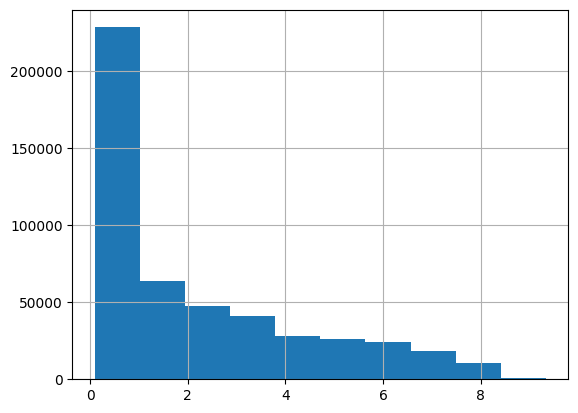

In [4]:
train = train[train["score"] > 0.1]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:06<00:00, 45.93it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7401


event   tolerance
onset   12           0.148754
        36           0.538287
        60           0.700465
        90           0.782339
        120          0.821340
        150          0.846527
        180          0.860743
        240          0.876657
        300          0.883388
        360          0.888009
wakeup  12           0.139680
        36           0.533994
        60           0.716806
        90           0.792223
        120          0.831524
        150          0.859062
        180          0.873262
        240          0.892800
        300          0.903264
        360          0.913430
dtype: float64